In [8]:
import os
import sys
import trace
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy.optimize import curve_fit
from matplotlib import cm, ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from typing import List, Dict, Tuple

import math
from scipy import integrate, interpolate, special
from scipy.special import erf

import emcee

root_dir = os.environ.get("ROOT_PATH")
if not root_dir in sys.path: sys.path.append(root_dir)

from src.utils.constants import *
from src.utils.CosmoFunc import rz_table

from src.filepaths import *
# from src.step_7_fit_fp import *

pvhub_dir = os.environ.get('PVHUB_DIR_PATH')
if not pvhub_dir in sys.path: sys.path.append(pvhub_dir)
from pvhub import * # type: ignore

import getdist
from getdist import plots, MCSamples

# Get environment variables from .env file
ROOT_PATH = os.environ.get('ROOT_PATH')
SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
COMPLETENESS_SETTING = int(os.environ.get('COMPLETENESS_SETTING'))
FP_FIT_METHOD = int(os.environ.get('FP_FIT_METHOD'))

In [2]:
# Read ALL_COMBINED FP slopes
df = pd.read_csv('../../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv', index_col=[0])
a, b = df.loc["ALL_COMBINED", ['a', 'b']].to_numpy()

df.head()

,a,b,rmean,smean,imean,s1,s2,s3
6dFGS,1.421104,-0.884526,0.187163,2.258860,3.214037,0.040353,0.275799,0.144861
SDSS,1.433664,-0.911374,0.154615,2.237387,3.184806,0.043745,0.263430,0.162176
LAMOST,1.439769,-0.932648,-0.044800,2.168487,3.292357,0.047785,0.264946,0.158394
SDSS_LAMOST,1.424907,-0.902153,0.108407,2.221795,3.213524,0.044973,0.270911,0.162773
ALL_COMBINED,1.435864,-0.897410,0.149478,2.243194,3.214366,0.043863,0.274185,0.154164


# Change FP_Func and FNFunc

In [6]:
def FN_func(FPparams, zobs, er, es, ei, lmin, lmax, smin):

    rmean, smean, imean, sigma1, sigma2, sigma3 = FPparams
    a = 1.435864
    b = -0.897410
    k = 0.0

    fac1, fac2, fac3, fac4 = k*a**2 + k*b**2 - a, k*a - 1.0 - b**2, b*(k+a), 1.0 - k*a
    norm1, norm2 = 1.0+a**2+b**2, 1.0+b**2+k**2*(a**2+b**2)-2.0*a*k
    dsigma31, dsigma23 = sigma3**2-sigma1**2, sigma2**2-sigma3**3
    sigmar2 =  1.0/norm1*sigma1**2 +      b**2/norm2*sigma2**2 + fac1**2/(norm1*norm2)*sigma3**2
    sigmas2 = a**2/norm1*sigma1**2 + k**2*b**2/norm2*sigma2**2 + fac2**2/(norm1*norm2)*sigma3**2
    sigmai2 = b**2/norm1*sigma1**2 +   fac4**2/norm2*sigma2**2 + fac3**2/(norm1*norm2)*sigma3**2
    sigmars =  -a/norm1*sigma1**2 -   k*b**2/norm2*sigma2**2 + fac1*fac2/(norm1*norm2)*sigma3**2
    sigmari =  -b/norm1*sigma1**2 +   b*fac4/norm2*sigma2**2 + fac1*fac3/(norm1*norm2)*sigma3**2
    sigmasi = a*b/norm1*sigma1**2 - k*b*fac4/norm2*sigma2**2 + fac2*fac3/(norm1*norm2)*sigma3**2

    err_r = er**2 + np.log10(1.0 + 300.0/(LightSpeed*zobs))**2 + sigmar2
    err_s = es**2 + sigmas2
    err_i = ei**2 + sigmai2
    cov_ri = -1.0*er*ei + sigmari

    A = err_s*err_i - sigmasi**2
    B = sigmasi*cov_ri - sigmars*err_i
    C = sigmars*sigmasi - err_s*cov_ri
    E = err_r*err_i - cov_ri**2
    F = sigmars*cov_ri - err_r*sigmasi
    I = err_r*err_s - sigmars**2

    # Inverse of the determinant!!
    det = 1.0/(err_r*A + sigmars*B + cov_ri*C)

    # Compute all the G, H and R terms
    G = np.sqrt(E)/(2*F-B)*(C*(2*F+B) - A*F - 2.0*B*I)
    delta = (I*B**2 + A*F**2 - 2.0*B*C*F)*det**2
    Edet = E*det
    Gdet = (G*det)**2
    Rmin = (lmin - rmean - imean/2.0)*np.sqrt(2.0*delta/det)/(2.0*F-B)
    Rmax = (lmax - rmean - imean/2.0)*np.sqrt(2.0*delta/det)/(2.0*F-B)

    G0 = -np.sqrt(2.0/(1.0+Gdet))*Rmax
    G2 = -np.sqrt(2.0/(1.0+Gdet))*Rmin
    G1 = -np.sqrt(Edet/(1.0+delta))*(smin - smean)

    H = np.sqrt(1.0+Gdet+delta)
    H0 = G*det*np.sqrt(delta) - np.sqrt(Edet/2.0)*(1.0+Gdet)*(smin - smean)/Rmax
    H2 = G*det*np.sqrt(delta) - np.sqrt(Edet/2.0)*(1.0+Gdet)*(smin - smean)/Rmin
    H1 = G*det*np.sqrt(delta) - np.sqrt(2.0/Edet)*(1.0+delta)*Rmax/(smin - smean)
    H3 = G*det*np.sqrt(delta) - np.sqrt(2.0/Edet)*(1.0+delta)*Rmin/(smin - smean)

    FN = special.owens_t(G0, H0/H)+special.owens_t(G1, H1/H)-special.owens_t(G2, H2/H)-special.owens_t(G1, H3/H)
    FN += 1.0/(2.0*np.pi)*(np.arctan2(H2,H)+np.arctan2(H3,H)-np.arctan2(H0,H)-np.arctan2(H1,H))
    FN += 1.0/4.0*(special.erf(G0/np.sqrt(2.0))-special.erf(G2/np.sqrt(2.0)))

    # This can go less than zero for very large distances if there are rounding errors, so set a floor
    # This shouldn't affect the measured logdistance ratios as these distances were already very low probability!
    index = np.where(FN < 1.0e-15)
    FN[index] = 1.0e-15

    return np.log(FN)

# The likelihood function for the Fundamental Plane
def FP_func(params, logdists, z_obs, r, s, i, err_r, err_s, err_i, Sn, smin, lmin, lmax, C_m, sumgals=True, chi_squared_only=False, use_full_fn=True):
    
    rmean, smean, imean, sigma1, sigma2, sigma3 = params
    a = 1.435864
    b = -0.897410
    k = 0.0

    fac1, fac2, fac3, fac4 = k*a**2 + k*b**2 - a, k*a - 1.0 - b**2, b*(k+a), 1.0 - k*a
    norm1, norm2 = 1.0+a**2+b**2, 1.0+b**2+k**2*(a**2+b**2)-2.0*a*k
    dsigma31, dsigma23 = sigma3**2-sigma1**2, sigma2**2-sigma3**3
    sigmar2 =  1.0/norm1*sigma1**2 + b**2/norm2*sigma2**2 + fac1**2/(norm1*norm2)*sigma3**2
    sigmas2 = a**2/norm1*sigma1**2 + k**2*b**2/norm2*sigma2**2 + fac2**2/(norm1*norm2)*sigma3**2
    sigmai2 = b**2/norm1*sigma1**2 +   fac4**2/norm2*sigma2**2 + fac3**2/(norm1*norm2)*sigma3**2
    sigmars =  -a/norm1*sigma1**2 -   k*b**2/norm2*sigma2**2 + fac1*fac2/(norm1*norm2)*sigma3**2
    sigmari =  -b/norm1*sigma1**2 +   b*fac4/norm2*sigma2**2 + fac1*fac3/(norm1*norm2)*sigma3**2
    sigmasi = a*b/norm1*sigma1**2 - k*b*fac4/norm2*sigma2**2 + fac2*fac3/(norm1*norm2)*sigma3**2

    sigma_cov = np.array([[sigmar2, sigmars, sigmari], [sigmars, sigmas2, sigmasi], [sigmari, sigmasi, sigmai2]])

    # Compute the chi-squared and determinant (quickly!)
    cov_r = err_r**2 + np.log10(1.0 + 300.0/(LIGHTSPEED*z_obs))**2 + sigmar2
    cov_s = err_s**2 + sigmas2
    cov_i = err_i**2 + sigmai2
    cov_ri = -1.0*err_r*err_i + sigmari

    A = cov_s*cov_i - sigmasi**2
    B = sigmasi*cov_ri - sigmars*cov_i
    C = sigmars*sigmasi - cov_s*cov_ri
    E = cov_r*cov_i - cov_ri**2
    F = sigmars*cov_ri - cov_r*sigmasi
    I = cov_r*cov_s - sigmars**2	

    sdiff, idiff = s - smean, i - imean
    rnew = r - np.tile(logdists, (len(r), 1)).T
    rdiff = rnew - rmean

    det = cov_r*A + sigmars*B + cov_ri*C
    log_det = np.log(det)/Sn

    chi_squared = (A*rdiff**2 + E*sdiff**2 + I*idiff**2 + 2.0*rdiff*(B*sdiff + C*idiff) + 2.0*F*sdiff*idiff)/(det*Sn)

    # Calculate full f_n
    if use_full_fn:
        FN = FN_func(params, z_obs, err_r, err_s, err_i, lmin, lmax, smin) + np.log(C_m)
    # Compute the FN term for the Scut only
    else:
        delta = (A*F**2 + I*B**2 - 2.0*B*C*F)/det
        FN = np.log(0.5 * special.erfc(np.sqrt(E/(2.0*(det+delta)))*(smin-smean)))/Sn + np.log(C_m)

    if chi_squared_only:
        return chi_squared
    elif sumgals:
        return 0.5 * np.sum(chi_squared + log_det + 2.0 * FN)
    else:
        return 0.5 * (chi_squared + log_det)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


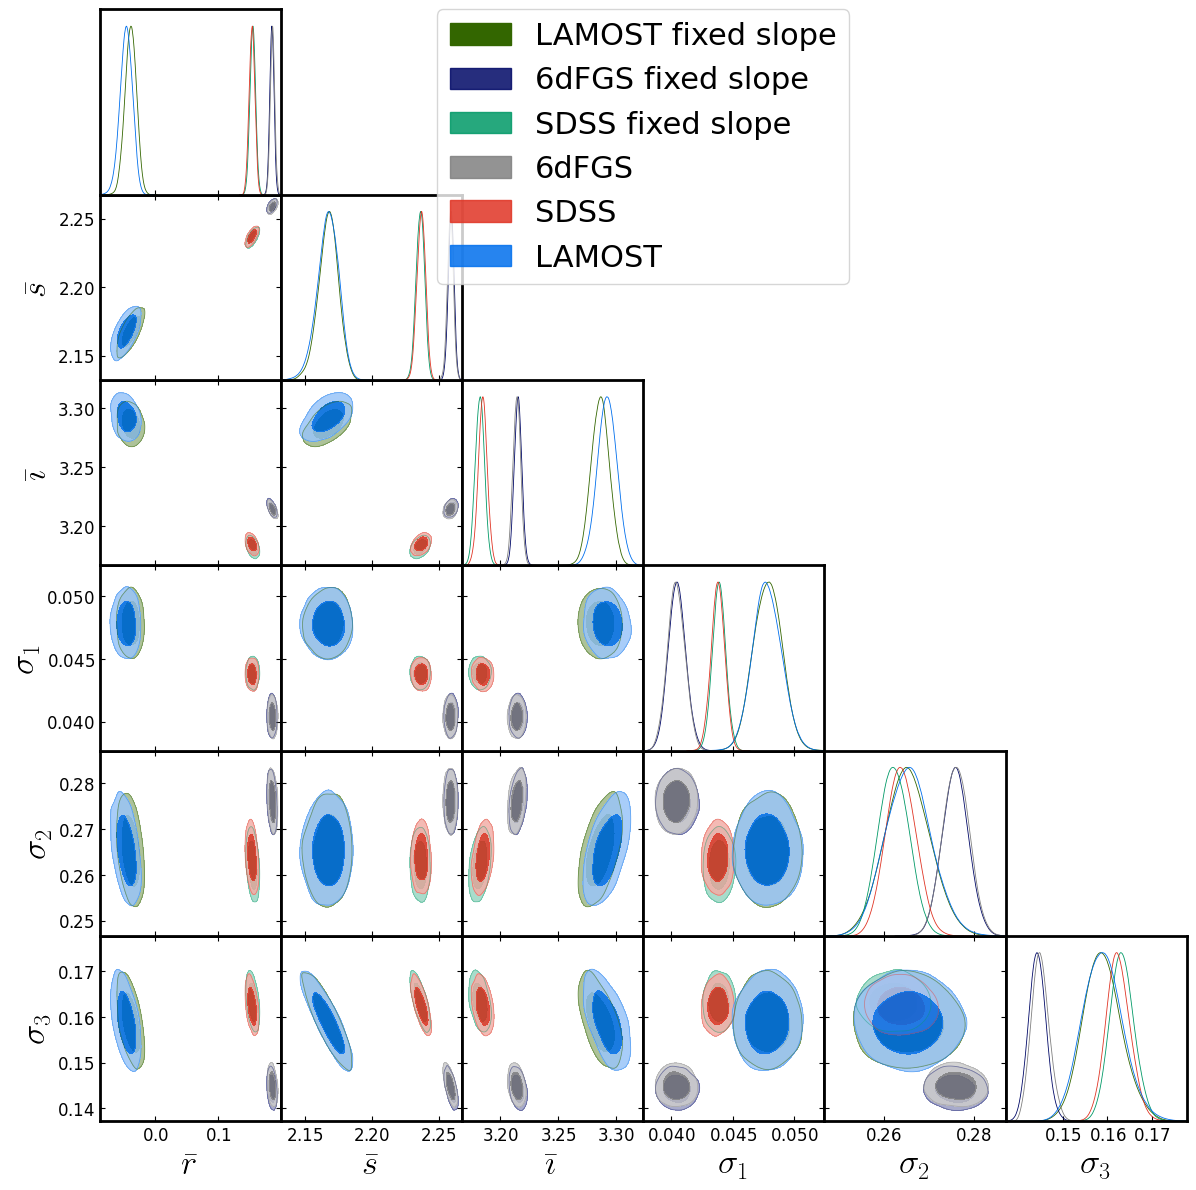

In [21]:
SMIN_SETTING = 1
FP_FIT_METHOD = 0

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['font.family'] = 'sans-serif'

# 6dFGS data
samples_6df = np.load("6dFGS_fixed_slope_chain.npy")
samples_6df_ori = np.load("../../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/6dfgs_chain.npy").T[2:].T

# SDSS data (mocks and previous values)
samples_sdss = np.load("SDSS_fixed_slope_chain.npy")
samples_sdss_ori = np.load("../../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/sdss_chain.npy").T[2:].T

# LAMOST data (mocks and previous values)
samples_lamost = np.load("LAMOST_fixed_slope_chain.npy")
samples_lamost_ori = np.load("../../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/lamost_chain.npy").T[2:].T

# parameter names
names = [r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']

samples1 = getdist.MCSamples(samples=samples_6df, names=names, label='6dFGS fixed slope')
samples2 = getdist.MCSamples(samples=samples_sdss, names=names, label='SDSS fixed slope')
samples3 = getdist.MCSamples(samples=samples_lamost, names=names, label='LAMOST fixed slope')

samples4 = getdist.MCSamples(samples=samples_6df_ori, names=names, label='6dFGS')
samples5 = getdist.MCSamples(samples=samples_sdss_ori, names=names, label='SDSS')
samples6 = getdist.MCSamples(samples=samples_lamost_ori, names=names, label='LAMOST')

# Triangle plot
g = getdist.plots.get_subplot_plotter()
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 20

g.triangle_plot([samples3, samples1, samples2, samples4, samples5, samples6], filled=True)

ndim = 6
for i in range(ndim):    
    for j in range(ndim):
        if j<=i:
            ax = g.subplots[i,j]
            # ax.axvline(prev_vals_6df[j], color='grey', ls='--', alpha=0.5)
            # ax.axvline(prev_vals_sdss[j], color='red', ls='--', alpha=0.5)
            # ax.axvline(prev_vals_lamost[j], color='green', ls='--', alpha=0.5)
            ax.set_xlabel(ax.get_xlabel(), usetex=True, fontsize=25, family='sans-serif')
            ax.set_ylabel(ax.get_ylabel(), usetex=True, fontsize=25, family='sans-serif')

            if i != j:
                pass
                # ax.axhline(prev_vals_6df[i], color='grey', ls='--', alpha=0.5)
                # ax.axhline(prev_vals_sdss[i], color='red', ls='--', alpha=0.5)
                # ax.axhline(prev_vals_lamost[i], color='green', ls='--', alpha=0.5)

g.export('../../img/temp_plot/fixed_slope.png', dpi=300)